In [1]:
# Set environment
# colab_env = 1 --> Google colab
# colab_env = 0 --> Local
print('Set the env for python. Enter "1" for Google-colab, "0" for local')
# colab_env = input()

Set the env for python. Enter "1" for Google-colab, "0" for local


In [2]:
colab_env=1
if colab_env ==1:
    print('Environment is set for Colab.')
    import pandas as pd
    import numpy as np
    import tensorflow as tf
    import os
    import shutil
    import glob
    home_dir = os.path.expanduser("~")
    content_dir = '/content'
    print('Home path is: '+home_dir)
    print('Home path is: '+home_dir)    
    print('Content path is: '+content_dir)
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Environment is set for Colab.
Home path is: /root
Home path is: /root
Content path is: /content
Num GPUs Available:  1


Data preparation

In [5]:
# Kaggle API token
! pip install -q kaggle
if colab_env ==1:
    from google.colab import files
    if os.path.isfile('./kaggle.json') == False:
        files.upload()
    print('Kaggle credential uploaded')

Kaggle credential uploaded


In [6]:
data_path = content_dir +'/data'
print('Data is stored at: '+data_path)
os.makedirs(content_dir+'/.kaggle',exist_ok = True)
os.system('cp kaggle.json '+str(home_dir) +'/.kaggle/')
os.system('chmod 600 '+str(home_dir)+'/.kaggle/kaggle.json')
os.system('kaggle competitions download -c mais202fall2021 -p '+data_path)
fname_zip = glob.glob(data_path+'/'+'*.zip'); print(fname_zip)
for i in range(len(fname_zip)):
    shutil.unpack_archive(fname_zip[i], './data')

Data is stored at: /content/data
['/content/data/test_images.npy.zip', '/content/data/train_images.npy.zip']


In [7]:
# show_image function 

import matplotlib.pyplot as plt

def show_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap="Greys")
    plt.show()


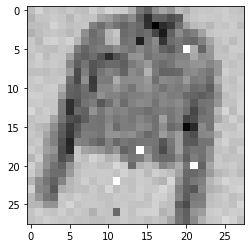

Training dataset (X) shape: (50000, 28, 28)
Test dataset (X) shape: (20000, 28, 28)
# of training labels (Y) shape: (50000, 1)


In [8]:
x_train = np.load(data_path+'/train_images.npy')/255
x_test = np.load(data_path+'/test_images.npy')/255

y_train = pd.read_csv(data_path+'/train_labels.csv', index_col=0)
y_train = pd.DataFrame(y_train).to_numpy()
y_train_arr = np.array(y_train.flatten())

show_image(x_train[1])

y_test_arr = np.array(pd.read_csv(data_path+'/sample_submission.csv')['label'])

# print(y_train)
print('Training dataset (X) shape: ',end = '')
print(x_train.shape)
print('Test dataset (X) shape: ',end = '')
print(x_test.shape)
print('# of training labels (Y) shape: ',end = '')
print(y_train.shape)

## Keras version 1

In [9]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adadelta, SGD
from keras.layers import (Input, Dense, Dropout, Conv2D, MaxPooling2D, Activation, BatchNormalization, Flatten)
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import keras
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



### Process data
Provided data has both images for training and testing, but only the training set has the label. This means we need to set a validation set, and cross-validation is possibly needed.

#### 1. Create a validation set

In [10]:
# set validation ratio
rto_cval = 0.2
# split the training data by randomly selecting images
def split_train_val(x_train,y_train,rto_cval = 0.2, ran_seeds = 0):
    # set numpy random seeds first, different seeds can be used for cross-validation 
    np.random.seed(ran_seeds)
    len_train = len(x_test) # length of orig. train
    val_count = int(rto_cval * len_train) # length of val
    ind_orig = np.linspace(0,len_train-1,len_train) # index for the input dataset
    # generate random index
    ind_val = np.random.randint(0, high=len_train-1, size=val_count, dtype=int)
    ind_new_train = np.array(list(set(ind_orig) - set(ind_val)),dtype=int)
    x_train_new = x_train[ind_new_train]
    y_train_new = y_train[ind_new_train]
    x_val = x_train[ind_val]
    y_val = y_train[ind_val]
    print('Random selected validation set has a length of '+ str(len(ind_val)))
    print('New training set has a length of '+ str(len(ind_new_train)))
    return x_train_new, y_train_new, x_val, y_val



##### *Data enhancement (adding noise)* ####

In [11]:
def adding_rand_noise(dataset,mean=0.0,sigma=0.1,ioption=0):
    if np.mod(ioption,2)==0:
        noise = np.random.randn(*dataset.shape)*sigma + mean # Gaussian noise
    else:
        noise = np.random.rand(*dataset.shape)*sigma + mean # Uniform noise
    return noise+dataset

### Define a CNN model with Keras 

In [18]:
# define cnn model
def define_model():
    model = Sequential()
    # 1st conv layer
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # 2nd conv layer
    model.add(Conv2D(32, (3, 2), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (2, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D((2, 2)))
    # FC
    model.add(Flatten())
    model.add(Dense(400, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(35, activation='log_softmax'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = Adam(learning_rate=0.0025, decay=1e-5)
    # opt = Adadelta(learning_rate=1, decay=2e-1)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])#
    model.summary()
    return model

model = define_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 batch_normalization_12 (Bat  (None, 26, 26, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 13, 13, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 12, 32)        3104      
                                                                 
 batch_normalization_13 (Bat  (None, 11, 12, 32)      

In [15]:
def y_to_label(y_test):
    plain_pred = list()
    for i in range(len(predictions)):
        plain_pred.append(list(predictions[i]).index(max(predictions[i])))
    new_array = pd.DataFrame(plain_pred)
    new_array.columns=['label']
    y_true = pd.read_csv(data_path+'/sample_submission.csv')
    icount = 0
    for i in range(len(y_true)):
        if new_array['label'][i]== y_true['label'][i]:
            icount+=1
    score = icount/len(y_true)
    return new_array['label']
    



#### 2. Train the network

I am considering the following ideas to train the model:

* Large batch size for some general features (with smaller training set)
* Small batch size (w/ or w/o noises) with a slightly higher epoch number for the local optima
* large batch size to end a round of training

*Noises:

I consider both Gaussian noise and uniform noises. It depends on the round of training (odd or even number).

*Cross-validation

Randomly selected validation set is used for training the network (the seed for numpy also varies each time).



In [21]:
x_train_new, y_train_new, x_val, y_val = split_train_val(x_train,y_train,rto_cval=0.2, ran_seeds=0)
print(x_train_new.shape)
# train the network

for i in range(1):
    print(" === Training model..., round # "+str(i))
    x_train_new, y_train_new, x_val, y_val = split_train_val(x_train,y_train,rto_cval=0.2, ran_seeds=0)
    H = model.fit(x=x_train_new, y=to_categorical(y_train_new,10),
        validation_data=(x_val, to_categorical(y_val,10)),
        batch_size=200, epochs=1)

    x_train_new, y_train_new, x_val, y_val = split_train_val(x_train,y_train,rto_cval=0.2, ran_seeds=1+i)
    x_train_noised = adding_rand_noise(x_train_new,0.5,i)
    H = model.fit(x=x_train_noised, y=to_categorical(y_train_new,10),
        validation_data=(x_val, to_categorical(y_val,10)),
        batch_size=50, epochs=3)
    
    x_train_new, y_train_new, x_val, y_val = split_train_val(x_train,y_train,rto_cval=0.2, ran_seeds=2+i)
    H = model.fit(x=x_train_new, y=to_categorical(y_train_new,10),
        validation_data=(x_val, to_categorical(y_val,10)),
        batch_size=5, epochs=1)

    x_train_new, y_train_new, x_val, y_val = split_train_val(x_train,y_train,rto_cval=0.2, ran_seeds=3+i)
    x_train_noised = adding_rand_noise(x_train_new,0.1,i)
    H = model.fit(x=x_train_noised, y=to_categorical(y_train_new,10),
        validation_data=(x_val, to_categorical(y_val,10)),
        batch_size=25, epochs=2)


    x_train_new, y_train_new, x_val, y_val = split_train_val(x_train,y_train,rto_cval=0.2, ran_seeds=4+i)
    H = model.fit(x=x_train_new, y=to_categorical(y_train_new,10),
        validation_data=(x_val, to_categorical(y_val,10)),
        batch_size=15, epochs=3)
    
    x_train_new, y_train_new, x_val, y_val = split_train_val(x_train,y_train,rto_cval=0.2, ran_seeds=7+i)
    H = model.fit(x=x_train_new, y=to_categorical(y_train_new,10),
        validation_data=(x_val, to_categorical(y_val,10)),
        batch_size=250, epochs=1)
    


Random selected validation set has a length of 4000
New training set has a length of 16399
(16399, 28, 28)
 === Training model..., round # 0
Random selected validation set has a length of 4000
New training set has a length of 16399
82/82 [==============================] - 1s 18ms/step - loss: 0.8955 - accuracy: 0.6514 - val_loss: 0.8792 - val_accuracy: 0.7005
Random selected validation set has a length of 4000
New training set has a length of 16376
Epoch 1/3
328/328 [==============================] - 3s 9ms/step - loss: 0.9682 - accuracy: 0.6252 - val_loss: 1.3697 - val_accuracy: 0.5842
Epoch 2/3
328/328 [==============================] - 3s 9ms/step - loss: 0.9315 - accuracy: 0.6492 - val_loss: 1.5852 - val_accuracy: 0.4095
Epoch 3/3
328/328 [==============================] - 3s 9ms/step - loss: 0.9116 - accuracy: 0.6601 - val_loss: 1.3328 - val_accuracy: 0.5400
Random selected validation set has a length of 4000
New training set has a length of 16367
3274/3274 [======================

In [22]:
y_test=model.predict(x_test)
predictions = y_test
plain_pred = list()
print(predictions[:5])

df_test = pd.read_csv(data_path+'/sample_submission.csv')
# fname_str=data_path+'/predictions_'+str(dt_string)+'.csv'
# df_test.to_csv('fname_str',index=False)


for i in range(len(predictions)):
    plain_pred.append(list(predictions[i]).index(max(predictions[i])))

print(plain_pred[:5])
import datetime
now = datetime.datetime.now()
dt_string =now.strftime("%Y%d%m_%H%M%S")
fname_str=data_path+'/predictions_'+str(dt_string)+'.csv'
print(fname_str)
new_array = pd.DataFrame(plain_pred)
new_array.columns=['label']
df_test['label'] = new_array['label']
print(df_test[:5])
df_test.to_csv(fname_str,index=False)
from google.colab import files

files.download(fname_str)


[[2.4326579e-23 4.4324955e-25 7.4221595e-24 3.0495639e-21 1.6299877e-20
  1.1909233e-14 1.0944258e-21 4.1165993e-08 4.1428352e-20 1.0000000e+00]
 [2.3676010e-23 1.6706793e-28 9.4159107e-23 3.4151342e-25 6.0131997e-22
  1.0000000e+00 4.1543264e-19 3.0882762e-15 3.3504664e-21 1.7854023e-14]
 [7.3922501e-04 4.6619025e-05 3.1621903e-01 8.9087657e-04 4.8526725e-01
  1.5041925e-05 1.9600400e-01 8.0409645e-06 8.0863596e-04 1.3029108e-06]
 [5.6917139e-27 1.0000000e+00 8.7981744e-32 9.0252501e-25 2.3908123e-27
  0.0000000e+00 8.4279404e-25 0.0000000e+00 2.3475547e-38 0.0000000e+00]
 [3.5365574e-21 5.7787949e-32 4.7744716e-20 4.8116255e-27 2.5155148e-23
  1.3004414e-21 2.0370611e-18 6.1809509e-30 1.0000000e+00 1.3366441e-28]]
[9, 5, 4, 1, 8]
/content/data/predictions_20212411_001026.csv
   ID  label
0   0      9
1   1      5
2   2      4
3   3      1
4   4      8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>